In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import time
from constants import (EXPORT_DIR, T, DATA_DIR, VAL_THRESHOLD, TEST_THRESHOLD, SEED)
import itertools
from collections import OrderedDict
import scipy
print(f"SciPy version: {scipy.__version__}")
import scipy.sparse as sp
import random
random.seed(SEED)

SciPy version: 1.5.2


In [2]:
import matplotlib.pyplot as plt
FONT_SIZE = 24
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
%config InlineBackend.figure_format ='retina'

In [3]:
%%time
df = pd.read_csv(DATA_DIR+'rees46-data-cleaned.csv',engine='c', sep=',',usecols=["user_id","csd"],
                 dtype={'user_id': np.int64,'csd':'category'})

Wall time: 133 ms


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433938 entries, 0 to 433937
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   csd      433938 non-null  category
 1   user_id  433938 non-null  int64   
dtypes: category(1), int64(1)
memory usage: 3.7 MB


In [5]:
new_user_id = pd.DataFrame()
new_user_id['user_id']=df.user_id.unique()
print(f"We will have {T.B}{len(new_user_id):,} unique users.{T.E}")
new_user_id.to_csv(DATA_DIR+'purchase_uid_key.csv', index = True, header=True)
uid_lookup = pd.Series(index=new_user_id.user_id,data=new_user_id.index)
uid_lookup = uid_lookup.to_dict(OrderedDict)
del new_user_id

We will have 82,534 unique users.


In [6]:
categories = set(df.csd)
print(f'There are {T.G}{len(categories)}{T.E} categories in the dataframe')

There are 123 categories in the dataframe


In [7]:
def pair_id_creator(df):
    """Creates pair ID for the dataframe 'df'
       we assume a single event type in the dataframe"""
    return df[['user_id','csd']].drop_duplicates().sort_values('user_id')

In [8]:
user_csd_pairs = pair_id_creator(df)
total_outcomes = len(user_csd_pairs)
print('Total outcomes:',total_outcomes)

Total outcomes: 219281


In [9]:
csd_value_counts = user_csd_pairs['csd'].value_counts()
csd_value_counts

electronics.smartphone              39663
computers.notebook                  12391
appliances.kitchen.refrigerators    10025
electronics.audio.headphone          9976
electronics.video.tv                 8383
                                    ...  
sport.diving                            4
country_yard.watering                   3
apparel.costume                         2
sport.snowboard                         2
apparel.shoes                           1
Name: csd, Length: 123, dtype: int64

# Probabilities including **all** categories

In [10]:
num_categories = len(csd_value_counts)

In [11]:
csd_key = pd.DataFrame()
csd_key['csd']=csd_value_counts.index
assert num_categories == len(csd_key), 'The number of categories must match regardless of method'
print(f"We will have {T.B}{len(csd_key):,}{T.E} unique categories.")
# csd_key.to_csv(DATA_DIR+'purchase_csd_key.csv', index = True, header=True)
csd_rlookup = pd.Series(index=csd_key.index,data=csd_key.csd)
csd_rlookup = csd_rlookup.to_dict(OrderedDict)
del csd_key

We will have 123 unique categories.


In [12]:
print(f'Last key is {T.B}{num_categories-1}{T.E}, representing {T.B}{csd_rlookup[num_categories-1]}{T.E}.')

Last key is 122, representing apparel.shoes.


In [13]:
def PAgivenB(A,B):
    P_B = csd_value_counts[B]/total_outcomes
    B_users = set(user_csd_pairs[user_csd_pairs['csd']==B]['user_id'])
    A_users = set(user_csd_pairs[user_csd_pairs['csd']==A]['user_id'])
    P_AiB = len(A_users.intersection(B_users))/total_outcomes
    return P_AiB / P_B

In [14]:
print('Probability of a user buying kettle given they bought a washer:',PAgivenB('appliances.kitchen.kettle','appliances.kitchen.washer'))

Probability of a user buying kettle given they bought a washer: 0.2057443480733684


In [15]:
%%time
P = np.zeros((num_categories, num_categories))
for i in range(num_categories):
    for j in range(num_categories):
        P[i,j] = PAgivenB(csd_rlookup[i],csd_rlookup[j]) 

Wall time: 22.1 s


In [16]:
a = 4
b = 7
print(f'Probability of {csd_rlookup[a]} given {csd_rlookup[b]}: {P[a,b]}')

Probability of electronics.video.tv given computers.peripherals.mouse: 0.21696891191709844


In [17]:
a = 90
b = 90
print(f'Probability of {csd_rlookup[a]} given {csd_rlookup[b]}: {P[a,b]}')

Probability of construction.components.faucet given construction.components.faucet: 1.0


In [18]:
a = 90
b = 94
print(f'Probability of {csd_rlookup[a]} given {csd_rlookup[b]}: {P[a,b]}')

Probability of construction.components.faucet given auto.accessories.radar: 0.0


In [19]:
P_Eye =  P-np.eye(num_categories, num_categories)
max_value = np.amax(P_Eye)
print('Maximum value of the array is:',max_value)
np.where(P_Eye == max_value)

Maximum value of the array is: 1.0


(array([ 0,  4, 13, 24], dtype=int64),
 array([122, 122, 122, 122], dtype=int64))

In [20]:
a = 0
b = 122
print(f'Probability of {csd_rlookup[a]} given {csd_rlookup[b]}: {P[a,b]}')

Probability of electronics.smartphone given apparel.shoes: 1.0


In [21]:
df[df['csd']=='apparel.shoes']

,csd,user_id
369724,apparel.shoes,1515915625512096000
384821,apparel.shoes,1515915625512096000


In [22]:
df[df['user_id']==1515915625512096000]

,csd,user_id
316751,electronics.video.tv,1515915625512096000
316759,electronics.smartphone,1515915625512096000
316760,appliances.environment.water_heater,1515915625512096000
316777,appliances.kitchen.hood,1515915625512096000
316780,appliances.kitchen.hood,1515915625512096000
316782,appliances.kitchen.hood,1515915625512096000
369724,apparel.shoes,1515915625512096000
384821,apparel.shoes,1515915625512096000


### **Conclusion:** we need to eliminate categories with very few purchases!

In [23]:
num_categories = int(len(csd_value_counts)*.2)
num_categories

24

In [24]:
csd_key = pd.DataFrame()
csd_key['csd']=csd_value_counts.index[:num_categories]
assert num_categories == len(csd_key), 'The number of categories must match regardless of method'
print(f"We will have {T.B}{len(csd_key):,}{T.E} unique categories.")
csd_key.to_csv(DATA_DIR+'purchase_csd_key.csv', index = True, header=True)
csd_rlookup = pd.Series(index=csd_key.index,data=csd_key.csd)
csd_rlookup = csd_rlookup.to_dict(OrderedDict)
csd_lookup = pd.Series(index=csd_key.csd,data=csd_key.index)
csd_lookup = csd_lookup.to_dict(OrderedDict)
del csd_key

We will have 24 unique categories.


In [25]:
print(f'Last key is {T.B}{num_categories-1}{T.E}, representing {T.B}{csd_rlookup[num_categories-1]}{T.E}.')

Last key is 23, representing appliances.kitchen.oven.


In [26]:
def PAgivenB(A,B):
    P_B = csd_value_counts[B]/total_outcomes
    B_users = set(user_csd_pairs[user_csd_pairs['csd']==B]['user_id'])
    A_users = set(user_csd_pairs[user_csd_pairs['csd']==A]['user_id'])
    P_AiB = len(A_users.intersection(B_users))/total_outcomes
    return P_AiB / P_B

In [27]:
print('Probability of a user buying kettle given they bought a washer:',PAgivenB('appliances.kitchen.kettle','appliances.kitchen.washer'))

Probability of a user buying kettle given they bought a washer: 0.2057443480733684


In [28]:
%%time
P = np.zeros((num_categories, num_categories))
for i in range(num_categories):
    for j in range(num_categories):
        P[i,j] = PAgivenB(csd_rlookup[i],csd_rlookup[j]) 

Wall time: 1.91 s


In [29]:
P_Eye =  P-np.eye(num_categories, num_categories)
max_value = np.amax(P_Eye)
print('Maximum value of the array is:',max_value)

Maximum value of the array is: 0.8182947019867549


In [30]:
(a,b) = np.where(P_Eye == max_value) 
a,b = a[0],b[0]
print(f'Probability of {csd_rlookup[a]} given {csd_rlookup[b]}: {P[a,b]}')
print(f'Probability of {csd_rlookup[b]} given {csd_rlookup[a]}: {P[b,a]}')

Probability of appliances.kitchen.hood given appliances.kitchen.oven: 0.8182947019867549
Probability of appliances.kitchen.oven given appliances.kitchen.hood: 0.48996282527881035


In [31]:
min_value = np.amin(P)
print('Minimum value of the array is:',min_value)
np.where(P_Eye == max_value)

Minimum value of the array is: 0.03217104102059854


(array([13], dtype=int64), array([23], dtype=int64))

In [32]:
(a,b) = np.where(P == min_value) 
a,b = a[0],b[0]
print(f'Probability of {csd_rlookup[a]} given {csd_rlookup[b]}: {P[a,b]}')

Probability of appliances.environment.fan given electronics.smartphone: 0.03217104102059854


# Predicting notebook sales

In [33]:
print(f"computers.notebook (id:{csd_lookup['computers.notebook']}) sales prediction")

computers.notebook (id:1) sales prediction


In [34]:
start_time = time.time()
number_of_users = df['user_id'].unique().shape[0]
number_of_features = num_categories

In [35]:
def user_experience_matrix(df,category_id_to_predict,print_freq=30000):
    last_index = df.shape[0]-1      
    # Use np.float32 for torch.cuda.FloatTensor.or np.float16 for torch.cuda.HalfTensor (float64 not recommended)
    uxm = sp.dok_matrix((number_of_users, number_of_features), dtype=np.float32)   
    print(f"       # |   User | {'Category':40} |  Previous |   {T.b}New UX{T.E}")
    ignored_keys = 0
    for row in df.itertuples():
        uid = uid_lookup[row.user_id]
        try:
            csd = csd_lookup[row.csd]            
            prev_ux = uxm[uid,csd]
            ux = np.tanh(prev_ux+P[category_id_to_predict,csd])   
            uxm[uid,csd] = ux
            if (row.Index % print_freq == 0) or (row.Index == last_index):
                print(f"{row.Index:8} | "+
                      f"{uid:6} | "+
                      f"{row.csd:40} |  "+
                      f"{prev_ux:8.5f} | "+
                      f"{T.b}{ux:8.5f}{T.E}")
        except KeyError:
            ignored_keys += 1
            if (row.Index % print_freq == 0) or (row.Index == last_index):
                print(f"{row.Index:8} | "+
                      f"{uid:6} | "+
                      f"{row.csd:40} |  "+
                      f"{T.R}   ignored category{T.E}")
    print(f'Ignored keys: {ignored_keys}')
    return uxm

In [36]:
%%time
uxm = user_experience_matrix(df,1)

       # |   User | Category                                 |  Previous |   New UX
       0 |      0 | electronics.tablet                       |   0.00000 |  0.30444
   30000 |  17192 | appliances.environment.vacuum            |   0.71106 |  0.74991
   60000 |  17556 | appliances.kitchen.microwave             |   0.00000 |  0.30472
   90000 |  18267 | stationery.battery                       |     ignored category
  120000 |  33666 | appliances.iron                          |   0.00000 |  0.31295
  150000 |  42946 | electronics.smartphone                   |   0.00000 |  0.14362
  180000 |  50869 | computers.notebook                       |   0.76159 |  0.94268
  210000 |  58459 | electronics.smartphone                   |   0.00000 |  0.14362
  240000 |  65079 | appliances.kitchen.meat_grinder          |   0.00000 |  0.34483
  270000 |  42529 | appliances.environment.vacuum            |   0.25587 |  0.47582
  300000 |  57768 | appliances.kitchen.microwave             |   0.30472 |  

In [37]:
print(f"Elapsed time: {time.time()-start_time:.2f} seconds")

Elapsed time: 9.40 seconds


# Train - test - validation split

In [38]:
def save_to_npz(X,path):
    X = X.tocoo()
    sp.save_npz(path,X)
    print(f"{T.G}Sparse matrix saved to: {path}{T.E}")

In [39]:
print(f"Train: {VAL_THRESHOLD*100:.2f}% \nValidation: {(1-TEST_THRESHOLD)*100:.2f}% \nTest: {(1-TEST_THRESHOLD)*100:.2f}%")

Train: 70.00% 
Validation: 15.00% 
Test: 15.00%


In [40]:
NNZ = uxm.nnz
print(f"Number of stored values: {NNZ:,}")

Number of stored values: 161,086


In [41]:
uxm.shape

(82534, 24)

In [42]:
%%time
uxm_train = sp.dok_matrix.copy(uxm)
uxm_val = sp.dok_matrix((number_of_users, number_of_features), dtype=np.float32) 
uxm_test = sp.dok_matrix((number_of_users, number_of_features), dtype=np.float32) 

Wall time: 1.32 s


In [43]:
%%time
rows,cols = uxm_train.nonzero()
for row,col in zip(rows,cols):
    rnd = random.random()
    if rnd > TEST_THRESHOLD:
        uxm_test[row,col] = uxm_train[row,col]
        uxm_train[row,col] = 0
    elif rnd > VAL_THRESHOLD:
        uxm_val[row,col] = uxm_train[row,col]
        uxm_train[row,col] = 0   

Wall time: 1.62 s


In [44]:
print(f"Number of train data values: {uxm_train.nnz:,} ({uxm_train.nnz*100/NNZ:.2f}%)")
print(f"Number of validation data values: {uxm_val.nnz:,} ({uxm_val.nnz*100/NNZ:.2f}%)")
print(f"Number of test data values: {uxm_test.nnz:,} ({uxm_test.nnz*100/NNZ:.2f}%)")
errormessage = '''All datapoints should be in either the train, the test of the validation datasets. 
The reason might be a change in how .nnz of a DOK matrix (scipy.sparse.dok_matrix) is calculated. 
In version 1.5.2 SciPy setting the value to zero explicitly (X[i,j]=0) is not counted by .nnz'''
assert NNZ - uxm_train.nnz - uxm_val.nnz - uxm_test.nnz == 0, errormessage

Number of train data values: 112,757 (70.00%)
Number of validation data values: 24,241 (15.05%)
Number of test data values: 24,088 (14.95%)


In [46]:
save_to_npz(uxm,DATA_DIR+r'uxm-purchase.npz')
save_to_npz(uxm_train,DATA_DIR+r'uxm_train-purchase.npz')
# save_to_npz(uxm_val,VAL_DATA_PATH)
# save_to_npz(uxm_test,TEST_DATA_PATH)

Sparse matrix saved to: ./data/uxm-purchase.npz
Sparse matrix saved to: ./data/uxm_train-purchase.npz


# Event types in the likelihood matrix

In [60]:
event_counts = df.csd.value_counts()[:num_categories]
event_counts

electronics.smartphone                    102554
computers.notebook                         25918
appliances.kitchen.refrigerators           20285
electronics.audio.headphone                20055
electronics.video.tv                       17625
appliances.environment.vacuum              15965
appliances.kitchen.washer                  14565
appliances.kitchen.kettle                  12713
computers.peripherals.mouse                12662
furniture.kitchen.table                    11233
appliances.kitchen.hood                     9053
appliances.kitchen.blender                  8668
appliances.iron                             8233
appliances.kitchen.microwave                7615
appliances.environment.air_conditioner      7378
appliances.personal.scales                  6714
computers.network.router                    6473
electronics.clocks                          6468
electronics.tablet                          6393
stationery.battery                          5183
computers.components

In [62]:
event_counts.sum()

343479

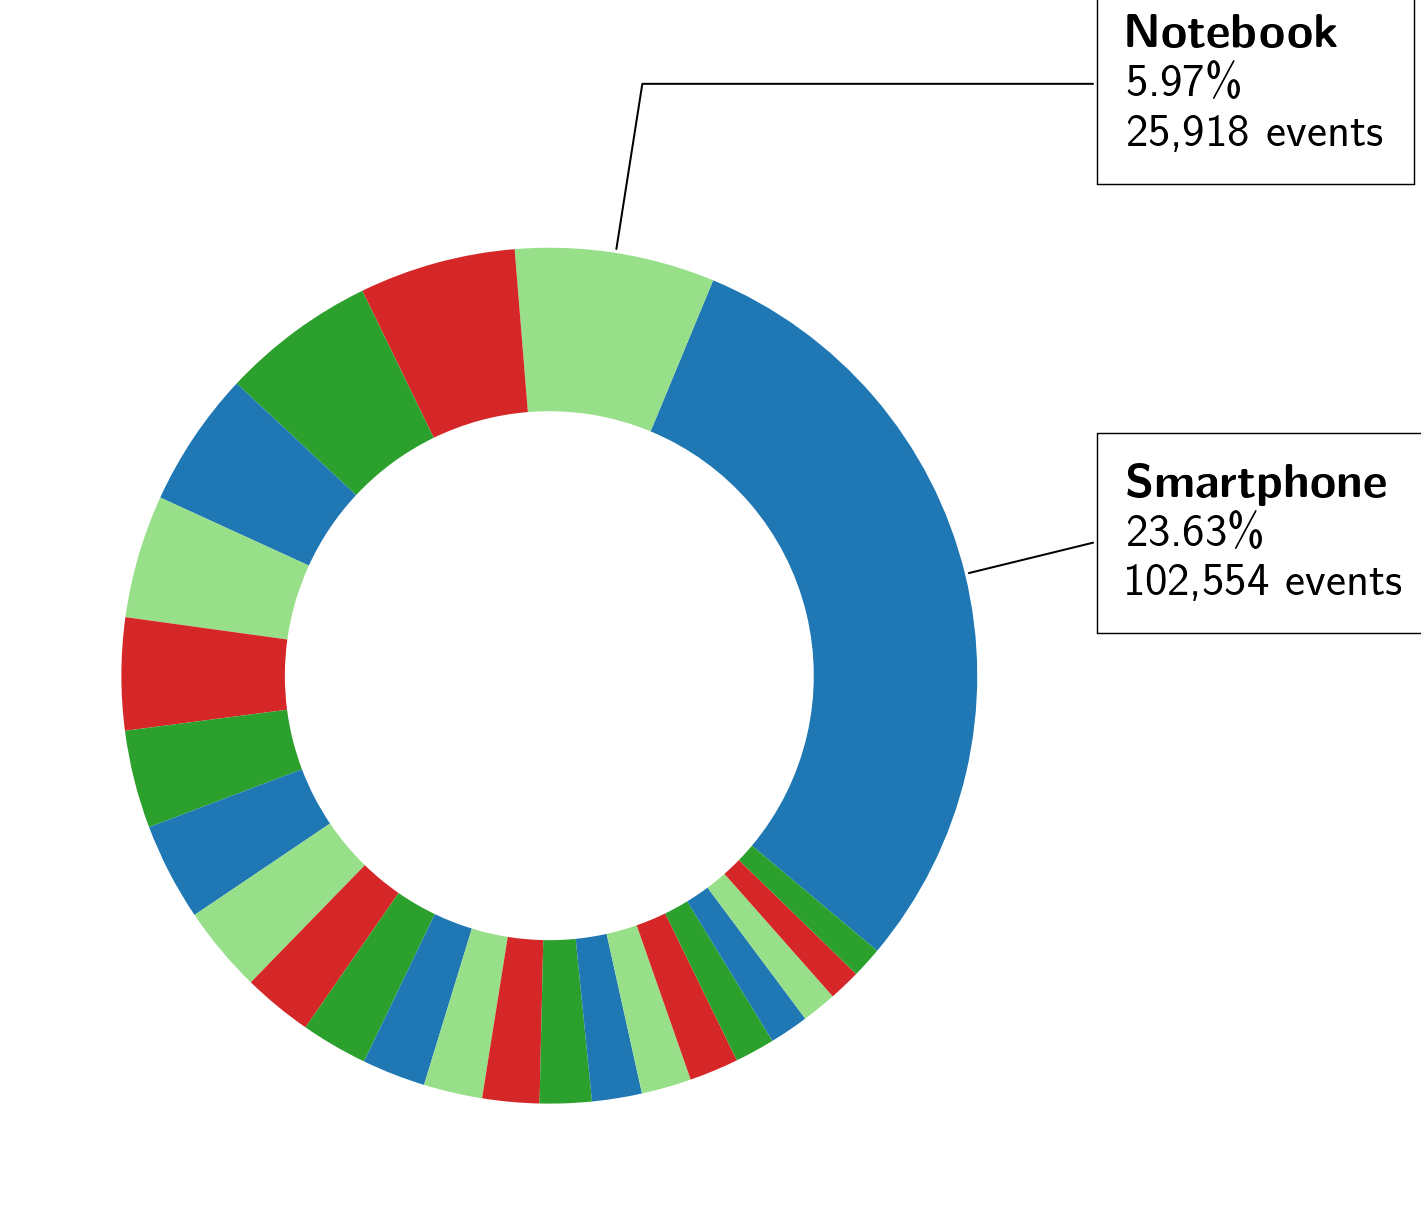

In [61]:
fig, ax = plt.subplots(figsize=(16, 9), subplot_kw=dict(aspect="equal"))
# W - width; P - precision; B - bold; N - normal
W = 2
P = 2
E = 'events'

event_perc = df.csd.value_counts(normalize=True)[:num_categories] * 100
event_type_legend = [r"\textbf{Smartphone}"+f"\n{event_perc['electronics.smartphone']:{W}.{P}f}\%\n{event_counts['electronics.smartphone']:,} {E}",
                     r"\textbf{Notebook}"+f"\n{event_perc['computers.notebook']:{W}.{P}f}\%\n{event_counts['computers.notebook']:,} {E}",
#                     r"\textbf{Refrigerator}"+f"\n{event_perc['appliances.kitchen.refrigerators']:{W}.{P}f}\%\n{event_counts['appliances.kitchen.refrigerators']:,} {E}",
#                      r"\textbf{Purchased}"+f"\n{event_perc['purchase']:{W}.{P}f}\%\n{event_counts['purchase']:,} {E}"
                    ]

cmap = plt.get_cmap("tab20")
wedges, texts = ax.pie(event_counts, wedgeprops=dict(width=0.382), textprops=dict(color="w"), startangle=-40, colors=cmap([0,5,6,4]))

bbox_props = dict(boxstyle="square,pad=0.618", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    if i <2:
        ax.annotate(event_type_legend[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),horizontalalignment=horizontalalignment, **kw)
fig.set_facecolor('w')
# ax.set_title("Logged user events")
plt.tight_layout()
fig.savefig(EXPORT_DIR+'purchase-percentage-of-events.png',dpi=300)
fig.savefig(EXPORT_DIR+'purchase-percentage-of-events.pdf')
plt.show()